<a href="https://colab.research.google.com/github/TMUITLab/EAFR/blob/master/EA15-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd '/content'
!git clone https://github.com/1049451037/GCN-Align
!git clone https://github.com/MaoXinn/RREA
!pip install opencv-python
!pip install numpy
!pip install matplotlib

/content
fatal: destination path 'GCN-Align' already exists and is not an empty directory.
fatal: destination path 'RREA' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [184]:
import warnings
warnings.filterwarnings('ignore')

from importlib.machinery import SourceFileLoader
from google.colab import files

layer = SourceFileLoader("layer", "/content/RREA/CIKM/layer.py").load_module()
utils = SourceFileLoader("utils", "/content/RREA/CIKM/utils.py").load_module()
CSLS = SourceFileLoader("CSLS", "/content/RREA/CIKM/CSLS.py").load_module()
import tensorflow as tf
import os
import time
import random
import keras
import pickle
from scipy.sparse import hstack
import math
from tqdm import *
import numpy as np
from utils import *
from CSLS import *
import tensorflow as tf
import keras.backend as K
from keras.layers import *
from layer import NR_GraphAttention
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [185]:
lang = 'im'
main_radj,train_pair,dev_pair,adj_matrix,r_index,r_val,adj_features,rel_features,nadj,char_size = load_data('/content/GCN-Align/data/%s_en/'%lang,train_ratio=0.30)
train_pair_main=train_pair
adj_matrix = np.stack(adj_matrix.nonzero(),axis = 1)
main_rel_matrix,rel_val = np.stack(rel_features.nonzero(),axis = 1),rel_features.data
ent_matrix,ent_val = np.stack(adj_features.nonzero(),axis = 1),adj_features.data

5000 8


In [186]:
rel_size = rel_features.shape[1] 


# pair_dic = dict()
# pairs = np.concatenate((dev_pair , train_pair),axis=0)
# for i in range(len(pairs)):
#     pair_dic[pairs[i][0]] = pairs[i][1]


main_rel_matrix1 = main_rel_matrix.copy()
for i in range(len(main_rel_matrix1)):
  main_rel_matrix1[i,1] = (main_rel_matrix1[i,1] + rel_size//2) % rel_size

main_radj1 = np.array(sorted(main_radj.copy(),key=lambda x: x[1]*10e10+x[0]*10e5))
for i in range(len(main_radj1)):
  _x,_y = main_radj1[i,0],main_radj1[i,1]
  main_radj1[i,0] = _y
  main_radj1[i,1] = _x
  main_radj1[i,2] = main_radj1[i,2] #( + rel_size//2) % rel_size
single_triple_set = set()
degree = np.zeros([adj_features.shape[0],3])
for triple in main_radj:
    single_triple_set.add((triple[0],triple[1]))
    if triple[2] < rel_size //2:
        degree[triple[0],0] += 1
        degree[triple[1],0] += 1
        degree[triple[0],2] += 1
        degree[triple[1],1] += 1

dev_pair_degrees = np.zeros([2,len(dev_pair),3])
for i in range(len(dev_pair)):
    dev_pair_degrees[0,i,0] = degree[dev_pair[i][0],0]
    dev_pair_degrees[0,i,1] = degree[dev_pair[i][0],1]
    dev_pair_degrees[0,i,2] = degree[dev_pair[i][0],2]
    dev_pair_degrees[1,i,0] = degree[dev_pair[i][1],0]
    dev_pair_degrees[1,i,1] = degree[dev_pair[i][1],1]
    dev_pair_degrees[1,i,2] = degree[dev_pair[i][1],2]

train_pair_degrees = np.zeros([2,len(train_pair),3])
for i in range(len(train_pair)):
    train_pair_degrees[0,i,0] = degree[train_pair[i][0],0]
    train_pair_degrees[0,i,1] = degree[train_pair[i][0],1]
    train_pair_degrees[0,i,2] = degree[train_pair[i][0],2]
    train_pair_degrees[1,i,0] = degree[train_pair[i][1],0]
    train_pair_degrees[1,i,1] = degree[train_pair[i][1],1]
    train_pair_degrees[1,i,2] = degree[train_pair[i][1],2]

ent_size = adj_features.shape[0]
depth = 3
deg = np.zeros([ent_size])
deg_in = np.zeros([ent_size])
deg_out = np.zeros([ent_size])
bdeg = np.zeros([ent_size])


single_graph = dict()
for h,t,r in main_radj:
    deg[h] += 1
    deg[t] += 1
    deg_in[t] += 1
    deg_out[h] += 1
    if(h not in single_graph):
        single_graph[h] = [t]
    else:
        single_graph[h] += [t]
for i in range(ent_size):
    bdeg[i] = math.floor(math.log(i+1))

bin = int(max(bdeg))
rec_deg = np.zeros([ent_size,bin*depth])
for h in single_graph:
    set_len = len(single_graph[h])
    for i in single_graph[h]:
        rec_deg[h,int(bdeg[i])] += 1/set_len
for d in range(1,depth):
    
    for h in single_graph:
        set_len = len(single_graph[h])
        for i in single_graph[h]:
            rec_deg[h,d*bin:(d+1)*bin] += (rec_deg[i,(d-1)*bin:(d)*bin])/set_len


In [187]:
entity1, rel1, triples1 = load_triples('/content/GCN-Align/data/%s_en/'%lang + 'triples_1')
num_entity_1 = len(entity1)
num_rel_1 = len(rel1)

In [191]:
layer = SourceFileLoader("layer", "/content/RREA/CIKM/layer.py").load_module()

from layer import NR_GraphAttention
tf.keras.backend.clear_session()
radj = main_radj
radj1 = main_radj1
rel_matrix = main_rel_matrix
rel_matrix1 = main_rel_matrix1
node_size = adj_features.shape[0]
rel_size = rel_features.shape[1]
triple_size = len(adj_matrix)
batch_size = node_size
datas = []
# e stand for entity ,r stand for relation , E stand for encoder(e), c stand for character embedding , R stand for encoder(r)
run_name = 'QeER'

def getMax(d):
    l = list(d.keys())
    random.shuffle(l)
    m = 0 
    max_key = -1;
    num_max = 0
    for k in l : 
        if d[k] > m :
            max_key = k
            m = d[k]
            num_max = 1
        elif d[k] == m:
            num_max += 1
    if num_max > 1:
        max_key = -1
    return max_key

def get_match_relations(tpair , threshold = 50):
    rmap_predict = dict()
    temp_train_pair_dic = dict()
    for i in range(len(tpair)):
        temp_train_pair_dic[tpair[i][0]] = tpair[i][1]
    triple_dic = dict()
    for h,t,r in radj:
        if r < (rel_size //2) :
            if (h,t) in triple_dic:
                triple_dic[(h,t)] += [r]
            else:
                triple_dic[(h,t)] = [r]
    for h,t,r in radj:
        if h in temp_train_pair_dic and t in temp_train_pair_dic and h != t and r < rel_size //2:
            z = np.zeros([rel_size])
            if (temp_train_pair_dic[h],temp_train_pair_dic[t]) in triple_dic:
                z[triple_dic[(temp_train_pair_dic[h],temp_train_pair_dic[t])]] = 1
                if r in rmap_predict :
                    rmap_predict[r] += z
                else:
                    rmap_predict[r] = z
    i = 0
    matched_dic = dict()
    for key in rmap_predict:
        v = np.max(rmap_predict[key])
        i += 1
        if(v>threshold):
            a = np.argmax(rmap_predict[key]) % (rel_size//2)
            matched_dic[key] = a
    #print(matched_dic);
    return matched_dic

def complete_graph(tpair,threshold=2,num = 10):
    
    new_train_pair = tpair.copy()
    for i in range(num):
        train_pair_dic1 = dict()
        for a,b in new_train_pair : 
            train_pair_dic1[a] = b
        selected_rmap = get_match_relations(new_train_pair,threshold)
        print('number of matched relation is : ' ,len(selected_rmap) )
        si = dict()
        so = dict()

        for h,t,r in radj:
          if (t,r) not in si:
            si[(t,r)] = [h]
          else:
            si[(t,r)] += [h]

          if (h,r) not in so:
            so[(h,r)] = [t]
          else:
            so[(h,r)] += [t]

        lmap = dict()
        rmap = dict()
        tmap = dict()
        for h,t,r in radj:
            if h in train_pair_dic1 and r in selected_rmap :
                if (train_pair_dic1[h],selected_rmap[r]) in so:
                    for t1 in so[(train_pair_dic1[h],selected_rmap[r])]:
                        if t not in lmap:
                            lmap[t] = dict()
                        if t1 not in lmap[t]:
                            lmap[t][t1] = 1
                        else:
                            lmap[t][t1] += 1

            if t in train_pair_dic1 and r in selected_rmap  :
                if (train_pair_dic1[t],selected_rmap[r]) in si:
                    for h1 in si[(train_pair_dic1[t],selected_rmap[r])]:
                        if h not in rmap:
                            rmap[h] = dict()
                        if h1 not in rmap[h]:
                            rmap[h][h1] = 1
                        else:
                            rmap[h][h1] += 1
        for t in lmap:
            if t not in tmap:
                tmap[t] = dict()
            for key in lmap[t]:
                if key not in tmap[t]:
                    tmap[t][key] = lmap[t][key]
                else:
                    tmap[t][key] += lmap[t][key]

        for t in rmap:
            if t not in tmap:
                tmap[t] = dict()
            for key in rmap[t]:
                if key not in tmap[t]:
                    tmap[t][key] = rmap[t][key]
                else:
                    tmap[t][key] += rmap[t][key]
        l = []
        for a in tmap:
            if a not in train_pair_dic :
                train_pair_dic1[a] = getMax(tmap[a])
                l.append([a,train_pair_dic1[a] ])
             

        # for a,b in pairs:
        #     if a not in train_pair_dic :
        #       if a in tmap:
        #           train_pair_dic1[a] = getMax(tmap[a])
        #           l.append([a,train_pair_dic1[a] ])
        #       elif a in lmap:
        #           train_pair_dic1[a] = getMax(lmap[a])
        #           l.append([a,train_pair_dic1[a] ])
        #       elif a in rmap:
        #           train_pair_dic1[a] = getMax(rmap[a])
        #           l.append([a,train_pair_dic1[a]])

        s = 0
        if (len(l) == 0):
            return train_pair_dic1;
        new_train_pair = np.concatenate([new_train_pair,np.array(l)],axis=0)
        # for t in train_pair_dic1:
        #     if t not in train_pair_dic and pair_dic[t] == train_pair_dic1[t]:
        #         s += 1
        # print(s/(len(pair_dic)-len(train_pair_dic)),len(train_pair_dic1)-len(train_pair_dic))
    return train_pair_dic1

def replce_matched_relations(threshold = 50):
    matched_dic = get_match_relations(threshold)
    for i in range(len(radj)) :
        h = radj[i,0]
        t = radj[i,1]
        r = radj[i,2]
        if r in matched_dic :
            radj[i,2] = matched_dic[r]
        elif (r - rel_size//2) in matched_dic:
            radj[i,2] = matched_dic[(r - rel_size//2)]   + (rel_size//2)

    for i in range(len(rel_matrix)) :
        h = rel_matrix[i,0]
        r = rel_matrix[i,1]
        if r in matched_dic :
            rel_matrix[i,1] = matched_dic[r]
        elif (r - rel_size//2) in matched_dic:
            rel_matrix[i,1] = matched_dic[(r - rel_size//2)]   + (rel_size//2)


class TokenEmbedding(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return self.input_dim, self.output_dim

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs):
        return self.embeddings
    
def get_embedding(add_rel_feature = False,threshold = 50,depth = 2):
    inputs = [adj_matrix,r_index,r_val,rel_matrix,rel_matrix1,ent_matrix,radj,radj1,nadj]
    inputs = [np.expand_dims(item,axis=0) for item in inputs]
    if add_rel_feature == False:
        return get_emb.predict_on_batch(inputs)
    else:
        selected_rmap = get_match_relations(threshold)
        rselected_rmap = dict()
        i = 0
        for key in selected_rmap:
            rselected_rmap[key] = i
            rselected_rmap[selected_rmap[key]] = i
            i += 1
        f = np.zeros([node_size,len(selected_rmap)*depth])
        for h,t,r in radj:
            if r in rselected_rmap:
                f[h,rselected_rmap[r]] += 1./degree[h,2]
            
        for i in range(depth-1):
            for h,t,r in radj:
                f[h,(i+1)*depth:(i+2)*depth] += 1./degree[h,2] * f[t,(i)*depth:(i+1)*depth]

        f1 = get_emb.predict_on_batch(inputs)
        f1 = f1 / np.linalg.norm(f1,axis=-1,keepdims=True)
        f = f / np.linalg.norm(f,axis=-1,keepdims=True)
        f2 = np.concatenate([f,f1],axis=1)
        return f

def test(wrank = None):
    vec = get_embedding()
    return  get_hits(vec,dev_pair,wrank=wrank)

def draw(rs):
    image = cv2.imread('/content/GCN-Align/data/im_en/img.png')
    image1 = cv2.imread('/content/GCN-Align/data/im_en/img1.png')
    height,width = image.shape[:2]
    def get_pixel(idx):
        return (int(idx / width) , idx % width)
    print(height,width)
    img_last = cv2.hconcat((image, image1))
    
    for i in range(len(rs)):
        i1 = dev_pair[rs[i][0],1]
        i2 = dev_pair[rs[i][1],1]

        p1 = get_pixel(i1-height*width)
        p2 = get_pixel(i2-height*width)
        if abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])<=1:
            # if(p1[0]<10):
            #     print(p1,p2,rs[i],i,dev_pair[rs[i][0]],i1,i2)
            img_last[p1[0] , p1[1]+width] = np.array([0,0,255])
        else:
            img_last[p1[0] , p1[1]+width] = np.array([255,255,0])

        #print(p1)
    img_last = cv2.resize(img_last, (400,200), interpolation = cv2.INTER_AREA)
    cv2_imshow(img_last)
    plt.show()

def CSLS_test(thread_number = 16, csls=10,accurate = True):
    vec = get_embedding()
    #vec =get_embedding(True,threshold = 2,depth = 1)
    trest_set_1 = [e1 for e1, e2 in dev_pair]
    trest_set_2 = [e2 for e1, e2 in dev_pair]
    Lvec = np.array([vec[e1] for e1, e2 in dev_pair])
    Rvec = np.array([vec[e2] for e1, e2 in dev_pair])

    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)

    # Lvec1 = np.array([rec_deg[e1] for e1, e2 in dev_pair])
    # Rvec1 = np.array([rec_deg[e2] for e1, e2 in dev_pair])

    # Lvec1 = 0.5 * Lvec1 / np.linalg.norm(Lvec1,axis=-1,keepdims=True)
    # Rvec1 = 0.5 * Rvec1 / np.linalg.norm(Rvec1,axis=-1,keepdims=True)

    # Lvec = np.concatenate([Lvec,Lvec1],axis=-1)
    # Rvec = np.concatenate([Rvec,Rvec1],axis=-1)

    # Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    # Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)

    lprec,ldata,_= eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], thread_number, csls=csls, accurate=accurate)
    results = np.zeros([len(dev_pair)])
    draw(list(lprec))
    for i in range(len(dev_pair)):
        if((i,i) in lprec):
            results[i] = 1

    datas.append((results,ldata))
    save_datas()
    return None

def save_datas():
    with open('/content/RREA/'+lang+"_"+run_name+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([train_pair_degrees,dev_pair_degrees,datas], f)

def load_datas():
    with open('/content/RREA/'+lang+"_"+run_name+'.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
        mydata =pickle.load(f)
    return mydata;

def get_train_set(batch_size = batch_size):
    negative_ratio =  batch_size // len(train_pair) + 1
    train_set = np.reshape(np.repeat(np.expand_dims(train_pair,axis=0),axis=0,repeats=negative_ratio),newshape=(-1,2))
    np.random.shuffle(train_set); train_set = train_set[:batch_size]
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,[train_set.shape[0],4])],axis = -1)
    return train_set

def get_train_set1(batch_size = batch_size):
    train_set = train_pair
    np.random.shuffle(train_set);
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,train_set.shape)],axis = -1)
    return train_set

def get_trgat(node_size,rel_size,node_hidden,rel_hidden,triple_size,n_attn_heads = 2,dropout_rate = 0,gamma = 3,lr = 0.005,depth = 2):
    adj_input = Input(shape=(None,2))
    index_input = Input(shape=(None,2),dtype='int64')
    val_input = Input(shape = (None,))
    rel_adj = Input(shape=(None,2))
    rel_adj1 = Input(shape=(None,2))
    ent_adj = Input(shape=(None,2))
    radj = Input(shape=(None,3),dtype='int64')
    radj1 = Input(shape=(None,3),dtype='int64')
    nadj = Input(shape=(None,3))
    
    # ent_emb = TokenEmbedding(node_size,node_hidden,embeddings_initializer="LecunNormal",trainable = True)(val_input) 
    # rel_emb = TokenEmbedding(rel_size,node_hidden,embeddings_initializer="LecunNormal",trainable = True)(val_input)
    # ch_emb = TokenEmbedding(char_size,node_hidden,embeddings_initializer="LecunNormal",trainable = True)(val_input)

    ent_emb = TokenEmbedding(node_size,node_hidden,trainable = True)(val_input) 
    rel_emb = TokenEmbedding(rel_size,node_hidden,trainable = True)(val_input)
    ch_emb = TokenEmbedding(char_size,node_hidden,trainable = True)(val_input)


    # E = TokenEmbedding(node_hidden,node_hidden,trainable = True)(val_input)
    # R = TokenEmbedding(node_hidden,node_hidden,trainable = True)(val_input)
    def ch_avg(tensor,size):
        n_adj = tf.squeeze(tensor[0],axis = 0)
        adj = K.cast(n_adj[:,0:2],dtype = "int64")   
        adj = tf.SparseTensor(indices=adj, values=tf.ones_like(n_adj[:,2],dtype = 'float32') , dense_shape=(node_size,size)) 
        adj = tf.compat.v1.sparse_softmax(adj) 
        l_adj = tf.compat.v1.sparse_tensor_dense_matmul(adj,tensor[1])
        return l_adj

    def avg(tensor,size):
        adj = K.cast(K.squeeze(tensor[0],axis = 0),dtype = "int64")   
        adj = tf.SparseTensor(indices=adj, values=tf.ones_like(adj[:,0],dtype = 'float32'), dense_shape=(node_size,size)) 
        adj = tf.compat.v1.sparse_softmax(adj) 
        l_adj = tf.compat.v1.sparse_tensor_dense_matmul(adj,tensor[1])
        return l_adj

    name_feature = Lambda(ch_avg,arguments={'size':char_size})([nadj,ch_emb])
    # rel_feature1 = Lambda(avg,arguments={'size':rel_size//2})([rel_adj,rel_emb])
    # rel_feature2 = Lambda(avg,arguments={'size':rel_size//2})([rel_adj1,rel_emb])
    rel_feature = Lambda(avg,arguments={'size':rel_size})([rel_adj,rel_emb])
    # rel_feature1= Lambda(avg,arguments={'size':node_size})([rel_adj,rel_feature])
    # rel_feature = 0.8 * rel_feature + 0.2 * rel_feature1

    ent_feature = Lambda(avg,arguments={'size':node_size})([ent_adj,ent_emb])
    ent_feature1 = Lambda(avg,arguments={'size':node_size})([ent_adj,ent_feature])
    ent_feature = 0.8 * ent_feature + 0.2 * ent_feature1
    # rel_emb = K.concatenate([rel_emb1,rel_emb2])
    #rel_feature = K.concatenate([rel_feature1,rel_feature2])

    encoder = NR_GraphAttention(node_size,activation="relu",
                                       rel_size = rel_size,
                                       depth =2,
                                       attn_heads=n_attn_heads,
                                       triple_size = triple_size,
                                       attn_heads_reduction='average',   
                                       dropout_rate=dropout_rate)
    encoder1 = NR_GraphAttention(node_size,activation="relu",
                                    rel_size = rel_size,
                                    depth = 2,
                                    attn_heads=n_attn_heads,
                                    triple_size = triple_size,
                                    attn_heads_reduction='average',   
                                    dropout_rate=dropout_rate)
    encoder2 = NR_GraphAttention(node_size,activation="relu",
                                       rel_size = rel_size,
                                       depth = 2,
                                       attn_heads=n_attn_heads,
                                       triple_size = triple_size,
                                       attn_heads_reduction='average',   
                                       dropout_rate=dropout_rate)
    opt1 = [rel_emb,adj_input,index_input,val_input,radj]
    opt2 = [rel_emb,adj_input,index_input,val_input,radj1]
    elements = []
    coefs = []
    for f_name in run_name:
        if f_name == 'e':
            elements += [ent_emb]
            coefs += [0.2]
        elif f_name == 'E':
            elements += encoder1([ent_feature]+opt1) 
            coefs += [0.8,0.8,0.8]
        elif f_name == 'R':
            elements += encoder1([rel_feature]+opt1) #+ encoder([rel_feature1]+opt2)
            coefs +=  [0.8,0.8,0.8]
        elif f_name == 'q':
            elements += [rel_feature1]
            coefs +=  [-0.5]
        elif f_name == 'C':
            elements += encoder2([name_feature]+opt1)
            coefs +=  [0.8,0.8,0.8]
        elif f_name == 'c':
            elements += [name_feature]
            coefs += [1.]

    #elements = [ent_emb] +   encoder([rel_feature]+opt1)+encoder([ent_feature]+opt1)
    #elements = [0.3 * ent_emb[:,:node_hidden//2]]+ el[0:3]+el[6:9]+[0.2 * ent_emb[:,node_hidden//2:]] + el[3:6]+el[9:12]
    num_el = elements.__len__()
    alpha =  tf.Variable([0.2], trainable=False)
    weight =  tf.Variable(coefs, trainable=False)
    #weight = (num_el-1)* tf.math.softmax(weight)
    #weight =  tf.Variable(1 * [-0.2,1.0] + (num_el-2) * [.8], trainable=False)
    print(weight)
    #elements = [alpha * elements[0]] + [elements[_i+1]*(1-alpha) for _i in range(len(elements)-1) ]
    elements = [elements[_i]*weight[_i] for _i in range(len(elements)) ]
    out_feature = Concatenate(-1)(elements)
    out_feature = Dropout(dropout_rate)(out_feature)
    
    alignment_input = Input(shape=(None,6),dtype = "int64") 
    #find = Lambda(lambda x:K.gather(reference=x[0],indices=K.cast(K.squeeze(x[1],axis=0), 'int32')))([out_feature,alignment_input])

    I = K.cast(K.squeeze(alignment_input,axis=0),dtype = "int64")
   
    A = K.sum(K.abs(K.gather(out_feature,I[:,0])-K.gather(out_feature,I[:,1])),axis=-1,keepdims=True)
    loss = 0.1 * ( K.relu(1 - K.sum(K.abs(K.gather(out_feature,I[:,0])))) +K.relu(1 - K.sum(K.abs(K.gather(out_feature,I[:,1])))))
    for i in range(2):
        B = K.sum(K.abs(K.gather(out_feature,I[:,0])-K.gather(out_feature,I[:,2+i])),axis=-1,keepdims=True)
        C = K.sum(K.abs(K.gather(out_feature,I[:,1])-K.gather(out_feature,I[:,2+i])),axis=-1,keepdims=True)
        loss += K.relu(gamma +A -B) + K.relu(gamma +A -C)
        loss += 0.1 * ( K.relu(1 - K.sum(K.abs(K.gather(out_feature,I[:,2+i])))))
    loss =  tf.compat.v1.reduce_sum(loss,keep_dims=True) / (batch_size)    
   
    inputs = [adj_input,index_input,val_input,rel_adj,rel_adj1,ent_adj,radj,radj1,nadj]
    train_model = keras.Model(inputs = inputs + [alignment_input],outputs = loss)
    
    train_model.compile(loss=lambda y_true,y_pred: y_pred,optimizer=tf.keras.optimizers.RMSprop(lr=lr))
    
    feature_model = keras.Model(inputs = inputs,outputs = out_feature)
    return train_model,feature_model

In [192]:
run_name = 'CeER'
model,get_emb = get_trgat(dropout_rate=0.3,node_size=node_size,rel_size=rel_size,n_attn_heads = 1,depth=2,gamma =3,node_hidden=20,rel_hidden = 20,triple_size = triple_size)
#model.summary(); 
initial_weights = model.get_weights()

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0.8, 0.8, 0.8, 0.2, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], dtype=float32)>


entity alignment started for dataset im CeER
iteration 1 start.


 20%|█▉        | 99/500 [00:18<00:51,  7.79it/s]

accurate results: hits@[1, 5, 10] = [47.05 89.97 96.22], mr = 3.346, mrr = 0.650, time = 2.589 s 
50 50


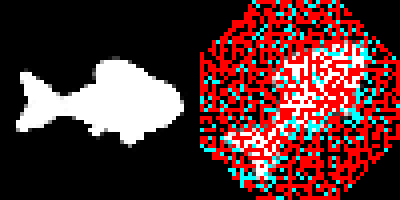

 40%|███▉      | 199/500 [00:34<00:36,  8.14it/s]

accurate results: hits@[1, 5, 10] = [55.15 98.01 99.66], mr = 1.867, mrr = 0.728, time = 2.472 s 
50 50


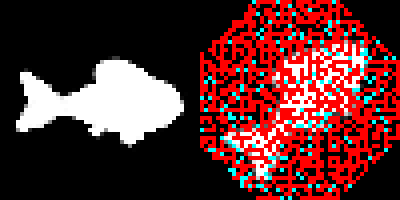

 60%|█████▉    | 299/500 [00:50<00:26,  7.67it/s]

accurate results: hits@[1, 5, 10] = [ 59.96  99.52 100.  ], mr = 1.663, mrr = 0.765, time = 2.472 s 
50 50


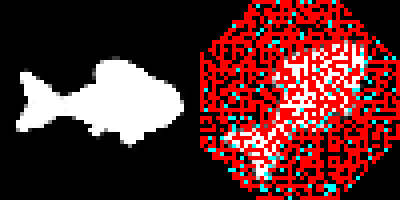

 80%|███████▉  | 399/500 [01:06<00:12,  7.90it/s]

accurate results: hits@[1, 5, 10] = [ 61.88  99.52 100.  ], mr = 1.595, mrr = 0.780, time = 2.772 s 
50 50


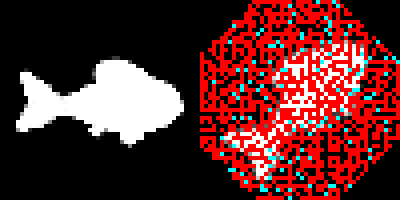

100%|██████████| 500/500 [01:21<00:00,  6.11it/s]


accurate results: hits@[1, 5, 10] = [ 63.39  99.79 100.  ], mr = 1.549, mrr = 0.791, time = 2.715 s 
50 50


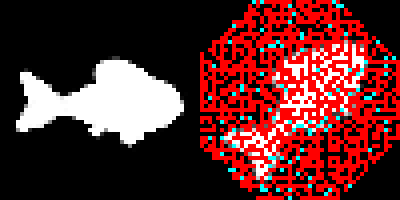

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  485 931 623
iteration 2 start.


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


accurate results: hits@[1, 5, 10] = [ 67.99  99.86 100.  ], mr = 1.457, mrr = 0.820, time = 2.731 s 
50 50


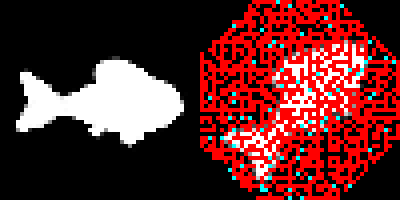

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  171 579 1108
iteration 3 start.


100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


accurate results: hits@[1, 5, 10] = [ 71.57 100.   100.  ], mr = 1.391, mrr = 0.842, time = 2.723 s 
50 50


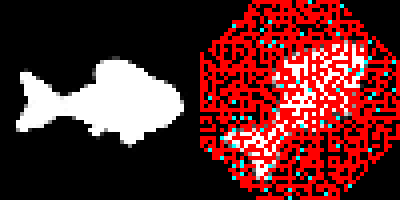

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  99 473 1279
iteration 4 start.


100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


accurate results: hits@[1, 5, 10] = [ 74.04 100.   100.  ], mr = 1.361, mrr = 0.855, time = 2.775 s 
50 50


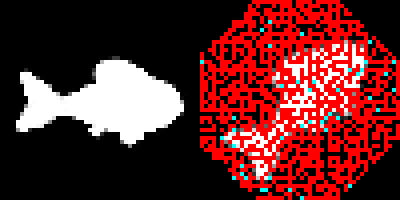

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  53 413 1378
iteration 5 start.


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


accurate results: hits@[1, 5, 10] = [ 75.69 100.   100.  ], mr = 1.332, mrr = 0.865, time = 2.706 s 
50 50


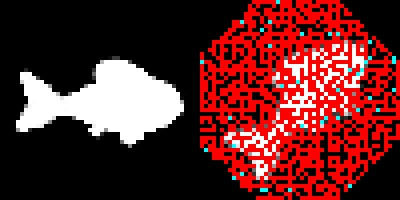

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  36 381 1431
iteration 6 start.


100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


accurate results: hits@[1, 5, 10] = [ 74.93 100.   100.  ], mr = 1.337, mrr = 0.862, time = 2.634 s 
50 50


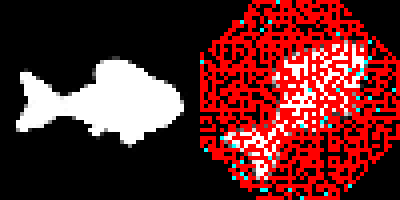

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  37 379 1467
iteration 7 start.


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


accurate results: hits@[1, 5, 10] = [ 75.14 100.   100.  ], mr = 1.331, mrr = 0.863, time = 2.520 s 
50 50


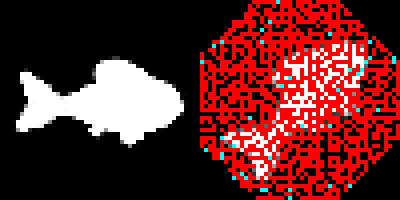

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  19 354 1504
iteration 8 start.


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


accurate results: hits@[1, 5, 10] = [ 77.27 100.   100.  ], mr = 1.298, mrr = 0.876, time = 2.601 s 
50 50


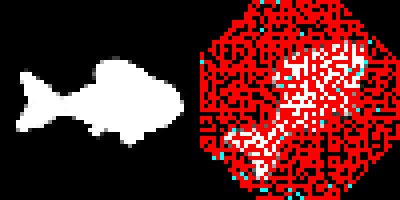

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  46 249 1681
iteration 9 start.


100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


accurate results: hits@[1, 5, 10] = [ 78.23 100.   100.  ], mr = 1.277, mrr = 0.882, time = 2.534 s 
50 50


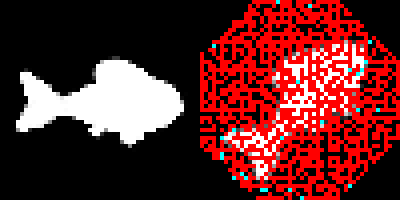

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  23 231 1727
iteration 10 start.


100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


accurate results: hits@[1, 5, 10] = [ 79.95 100.   100.  ], mr = 1.255, mrr = 0.891, time = 2.558 s 
50 50


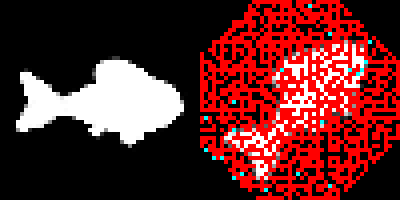

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  27 162 1842
iteration 11 start.


100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


accurate results: hits@[1, 5, 10] = [ 80.29 100.   100.  ], mr = 1.245, mrr = 0.894, time = 2.539 s 
50 50


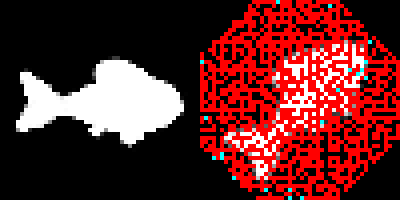

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  21 96 1942
iteration 12 start.


100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


accurate results: hits@[1, 5, 10] = [ 81.25 100.   100.  ], mr = 1.231, mrr = 0.899, time = 2.536 s 
50 50


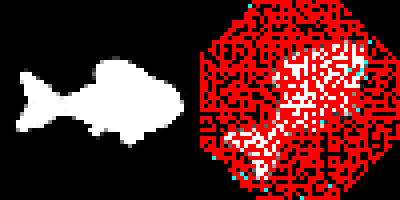

number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of matched relation is :  4
number of new pair , candidate pair, train pair:  3 30 2038
iteration 13 start.


100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


accurate results: hits@[1, 5, 10] = [ 81.59 100.   100.  ], mr = 1.219, mrr = 0.903, time = 2.552 s 
50 50


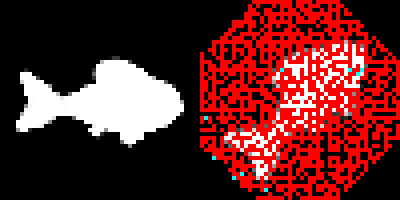

ValueError: ignored

In [193]:
train_pair = train_pair_main

train_pair_dic = dict()
for i in range(len(train_pair)):
    train_pair_dic[train_pair[i][0]] = train_pair[i][1]
    
radj = main_radj
radj1 = main_radj1
rel_matrix = main_rel_matrix
rel_matrix1 = main_rel_matrix1  
tf.keras.backend.clear_session()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True  
sess = tf.compat.v1.Session(config=config) 

rest_set_1 = [e1 for e1, e2 in dev_pair]
rest_set_2 = [e2 for e1, e2 in dev_pair]
np.random.shuffle(rest_set_1)
np.random.shuffle(rest_set_2)
print ('entity alignment started for dataset' , lang, run_name)
epoch = 500
hb = True
for turn in range(1,30):
    print("iteration %d start."%turn)
    for i in trange(epoch):
        cur_epoch = i
        train_set = get_train_set()
        
        inputs = [adj_matrix,r_index,r_val,rel_matrix,rel_matrix1,ent_matrix,radj,radj1,nadj,train_set]
        inputs = [np.expand_dims(item,axis=0) for item in inputs]
        model.train_on_batch(inputs,np.zeros((1,1)))
        #CSLS_test()
        if i%100 == 99 and i+1 != epoch:
            
            CSLS_test()     

    # if turn == 0:
    #     epoch = 100
    #     CSLS_test()
    #     break;
    CSLS_test()       
    new_pair1 = []
    new_pair = []
    if (len(rest_set_1) < 10 or len(rest_set_2) < 10):
        continue
    #vec = get_embedding()
    vec = get_embedding()
    Lvec = np.array([vec[e] for e in rest_set_1])
    Rvec = np.array([vec[e] for e in rest_set_2])
    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
    A,_,_ = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 16,10,True,False)
    B,_,_ = eval_alignment_by_sim_mat(Rvec, Lvec,[1, 5, 10], 16,10,True,False)
    A = sorted(list(A)); B = sorted(list(B))
    AB = dict()
    for a,b in A:
        if  B[b][1] == a:
            if rest_set_1[a] not in AB:
                AB[rest_set_1[a]] = 1
            else:
                AB[rest_set_1[a]] += 1
            if rest_set_2[b] not in AB:
                AB[rest_set_2[b]] = 1
            else:
                AB[rest_set_2[b]] += 1
    for a,b in A:
        if  B[b][1] == a  and AB[rest_set_1[a]] == 1 and AB[rest_set_2[b]] == 1 :
            new_pair1.append([rest_set_1[a],rest_set_2[b]])
    if hb :
        train_pair1 = np.concatenate([train_pair,np.array(new_pair1)],axis = 0)
        new_pair_dic = complete_graph(train_pair1,2,5) 
        
        for a,b in new_pair1:

              if (a in new_pair_dic and new_pair_dic[a] == b):
                  new_pair.append([a,b])
        print('number of new pair , candidate pair, train pair: ' , len(new_pair) , len(new_pair1), len(train_pair))
        if len(new_pair) < 30:
            if len(new_pair1) < 100:
                new_pair = new_pair1
            else:
                random.shuffle(new_pair1)
                new_pair = new_pair1[:min(max(len(new_pair1)//2,100),500)]
    else:
        new_pair = new_pair1
        print('number of new pair, training pair: ' , len(new_pair) , len(train_pair))

    epoch = 100 + 100 * (len(new_pair)//1000)
    if epoch > 500:
        epoch = 500

    # _,_,A = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 16,10,True,False)
    # _,_,B = eval_alignment_by_sim_mat(Rvec, Lvec,[1, 5, 10], 16,10,True,False)
    # A = A[0]
    # B = B[0]

    # for i in range(len(A)):
    #     if i == B[A[i,0],0]:
    #         has_other_pair = 0
    #         for _i in range(1,10):
    #             if(_i in B[A[i,_i],:10]):
    #                 has_other_pair = 1
    #                 break;

    #         if has_other_pair == 0:
    #               #print([rest_set_1[i],rest_set_2[A[i,j]]])
    #               new_pair.append([rest_set_1[i],rest_set_2[A[i,0]]])


    # new_pair_dic = complete_graph(train_pair,2,10) 
    # for a,b in new_pair1:
    #     if (a in new_pair_dic and new_pair_dic[a] == b):
    #         new_pair.append([a,b])

    train_pair = np.concatenate([train_pair,np.array(new_pair)],axis = 0)
    # s = 0
    # s1 = 0
    # for a,b in new_pair :
    #     if pair_dic[a] == b:
    #         s1 += 1
    # for a,b in train_pair:
    #     if a not in train_pair_dic and pair_dic[a] == b:
    #         s += 1

    #print("generate new semi-pairs: " + str(len(new_pair)) + ".  num of correct new pairs" + str(s1))
    #print("total new pairs: " + str(len(train_pair) - len(train_pair_dic)) + ".  num of correct new pairs " + str(s) +  "("+str(s/(len(train_pair) - len(train_pair_dic))) +")")
    for e1,e2 in new_pair:
        if e1 in rest_set_1:
            rest_set_1.remove(e1) 
        
    for e1,e2 in new_pair:
        if e2 in rest_set_2:
            rest_set_2.remove(e2)
            
    with open('/content/RREA/'+lang+"_"+run_name+'_train_pair'+str(turn)+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(train_pair, f)

    #complete_graph(train_pair,2,10)
    #match_relations()
# for turn in range(5):
#     files.download('/content/RREA/'+lang+"_"+run_name+'_train_pair'+str(turn)+'.pkl');
# files.download('/content/RREA/'+lang+"_"+run_name+'.pkl') 

In [ ]:
thread_number = 16
csls=10
accurate = True
vec = get_embedding()
trest_set_1 = [e1 for e1, e2 in dev_pair]
trest_set_2 = [e2 for e1, e2 in dev_pair]
Lvec = np.array([vec[e1] for e1, e2 in dev_pair])
Rvec = np.array([vec[e2] for e1, e2 in dev_pair])

Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)

# Lvec1 = np.array([rec_deg[e1] for e1, e2 in dev_pair])
# Rvec1 = np.array([rec_deg[e2] for e1, e2 in dev_pair])

# Lvec1 = 0.5 * Lvec1 / np.linalg.norm(Lvec1,axis=-1,keepdims=True)
# Rvec1 = 0.5 * Rvec1 / np.linalg.norm(Rvec1,axis=-1,keepdims=True)

# Lvec = np.concatenate([Lvec,Lvec1],axis=-1)
# Rvec = np.concatenate([Rvec,Rvec1],axis=-1)

# Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
# Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)

lprec,ldata,AB = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], thread_number, csls=csls, accurate=accurate)
  

In [154]:
s = 0
for i in  range(len(dev_pair)):
  if(AB[0][i,0] == i):
    s+=1 
print(s)

s = 0
res = list(lprec)
for i in  range(len(dev_pair)):
  if(res[i][0]  == res[i][1]):
    s+=1 
print(s)

849
840


In [57]:
result[0][0]

341

In [29]:
s = 0
for i in range(len(dev_pair)):
  if AB[0][i,0] == i:
      s += 1
print(s/len(dev_pair))
print(len(dev_pair),len(train_pair))


0.46596491228070175
1425 610


50 50
(9, 16) (9, 17) (1216, 793) 6 [ 430 2966] 2966 2967
(1, 11) (1, 11) (66, 66) 21 [ 646 2561] 2561 2561
(4, 28) (4, 28) (729, 729) 38 [ 692 2728] 2728 2728
(0, 41) (0, 41) (1000, 1193) 41 [ 289 2541] 2541 2541
(0, 41) (0, 39) (1193, 540) 43 [ 239 2541] 2541 2539
(0, 24) (0, 24) (13, 13) 66 [  67 2524] 2524 2524
(4, 29) (3, 29) (914, 1257) 94 [ 743 2729] 2729 2679
(9, 20) (9, 20) (118, 118) 99 [ 583 2970] 2970 2970
(1, 18) (1, 18) (1007, 1007) 106 [ 798 2568] 2568 2568
(5, 20) (5, 20) (696, 696) 121 [ 435 2770] 2770 2770
(5, 27) (4, 27) (1376, 84) 129 [ 691 2777] 2777 2727
(0, 29) (0, 31) (318, 892) 134 [  71 2529] 2529 2531
(3, 25) (2, 25) (1312, 1349) 135 [ 541 2675] 2675 2625
(6, 39) (6, 39) (178, 178) 136 [1148 2839] 2839 2839
(1, 9) (1, 9) (164, 164) 155 [ 595 2559] 2559 2559
(1, 5) (1, 5) (680, 680) 163 [ 494 2555] 2555 2555
(2, 13) (2, 13) (402, 402) 164 [  66 2613] 2613 2613
(6, 23) (6, 23) (461, 461) 171 [ 587 2823] 2823 2823
(0, 35) (0, 35) (307, 307) 172 [ 187 2535] 2535 

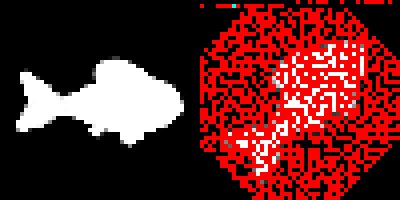

In [171]:
def draw(rs):
    image = cv2.imread('/content/GCN-Align/data/im_en/img.png')
    image1 = cv2.imread('/content/GCN-Align/data/im_en/img1.png')
    height,width = image.shape[:2]
    def get_pixel(idx):
        return (int(idx / width) , idx % width)
    print(height,width)
    img_last = cv2.hconcat((image, image1))
    
    for i in range(len(rs)):
        i1 = dev_pair[rs[i][0],1]
        i2 = dev_pair[rs[i][1],1]

        p1 = get_pixel(i1-height*width)
        p2 = get_pixel(i2-height*width)
        if abs(p1[0]-p2[0]) <= 2 and abs(p1[1]-p2[1])<=2:
            if(p1[0]<10):
                print(p1,p2,rs[i],i,dev_pair[rs[i][0]],i1,i2)
            img_last[p1[0] , p1[1]+width] = np.array([0,0,255])
        else:
            img_last[p1[0] , p1[1]+width] = np.array([255,255,0])

        #print(p1)
    img_last = cv2.resize(img_last, (400,200), interpolation = cv2.INTER_AREA)
    cv2_imshow(img_last)
    plt.show()
draw(list(lprec))

In [158]:
print(list(lprec))

[(1271, 83), (1020, 1316), (53, 53), (101, 235), (570, 570), (751, 1204), (1216, 793), (756, 756), (1292, 1292), (1314, 717), (1096, 1384), (710, 176), (223, 266), (297, 538), (763, 763), (159, 1042), (891, 891), (1157, 1157), (1279, 346), (1180, 642), (1328, 246), (66, 66), (446, 446), (818, 818), (1330, 1330), (480, 136), (1281, 1281), (1291, 691), (533, 1273), (1256, 899), (218, 218), (346, 346), (678, 678), (735, 1289), (806, 806), (1370, 1370), (167, 167), (14, 77), (729, 729), (857, 857), (962, 608), (1000, 1193), (1191, 1191), (1193, 540), (1319, 1319), (143, 664), (291, 291), (46, 293), (438, 438), (554, 554), (869, 869), (726, 726), (548, 548), (740, 740), (1015, 1015), (1033, 1033), (894, 1276), (79, 295), (210, 210), (338, 338), (686, 686), (1234, 1234), (529, 251), (1362, 1362), (1313, 1117), (329, 109), (13, 13), (115, 115), (149, 149), (141, 942), (277, 277), (875, 875), (1011, 1011), (1037, 1037), (441, 441), (1172, 1141), (337, 963), (642, 187), (564, 731), (952, 1151),

In [128]:
sum([x[0] != x[1] for x in res])/len(res)

0.5242105263157895

In [121]:
range(len(res))

range(0, 1425)

In [115]:
s = 0
for z in res:
  if z[0] == z[1]:
      s += 1
print(s)
res[3]

678


(454, 454)

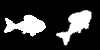

In [65]:
res = list(lprec)
image = cv2.imread('/content/GCN-Align/data/im_en/img.png')
image1 = cv2.imread('/content/GCN-Align/data/im_en/img1.png')
height,width = image.shape[:2]
def get_pixel(idx):
    return (int(idx / width) , idx % width)

img_last = cv2.hconcat((image, image1))
cv2_imshow(img_last)
